In [65]:
import pandas as pd                
import numpy as np                  
import matplotlib.pyplot as plt     
import seaborn as sns             
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor    
import xgboost as xgb              
from sklearn.metrics import mean_squared_error, r2_score  
import time                        
from joblib import Parallel, delayed  
import warnings
warnings.filterwarnings('ignore') 

In [66]:

data = pd.read_csv('flood.csv')
print(f"Dataset Shape: {data.shape[0]} rows × {data.shape[1]} columns")
print(f"Dataset Size: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset Shape: 50000 rows × 21 columns
Dataset Size: 8.01 MB


In [67]:
print("\n FIRST 5 ROWS:")
print(data.head())


 FIRST 5 ROWS:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ...  DrainageSystems  Coasta

In [68]:

print(f"\n Missing Values: {data.isnull().sum().sum()}")



 Missing Values: 0


In [69]:

print("\n BASIC STATISTICS:")
print(data.describe())


 BASIC STATISTICS:
       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
count      50000.000000        50000.000000      50000.00000   50000.000000   
mean           4.991480            4.984100          5.01594       5.008480   
std            2.236834            2.246488          2.23131       2.222743   
min            0.000000            0.000000          0.00000       0.000000   
25%            3.000000            3.000000          3.00000       3.000000   
50%            5.000000            5.000000          5.00000       5.000000   
75%            6.000000            6.000000          6.00000       6.000000   
max           16.000000           18.000000         16.00000      17.000000   

       Urbanization  ClimateChange  DamsQuality     Siltation  \
count  50000.000000   50000.000000  50000.00000  50000.000000   
mean       4.989060       4.988340      5.01536      4.988600   
std        2.243159       2.226761      2.24500      2.232642   
min     


 CREATING VISUALIZATIONS...


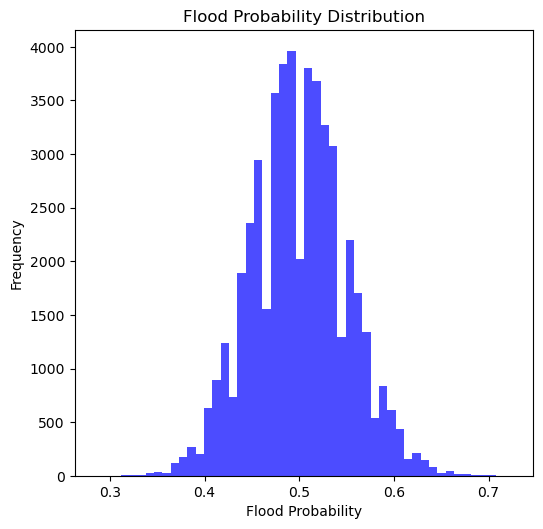

In [70]:

print("\n CREATING VISUALIZATIONS...")


plt.figure(figsize=(15, 10))


plt.subplot(2, 3, 1)
plt.hist(data['FloodProbability'], bins=50, color='blue', alpha=0.7)
plt.title('Flood Probability Distribution')
plt.xlabel('Flood Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

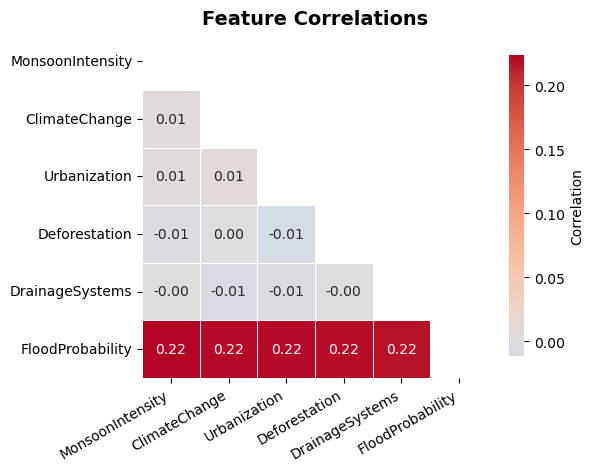

In [71]:
top_features = ['MonsoonIntensity', 'ClimateChange', 'Urbanization', 
                'Deforestation', 'DrainageSystems', 'FloodProbability']
correlation_matrix = data[top_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(6, 5))


sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Feature Correlations", fontsize=14, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Average Value')

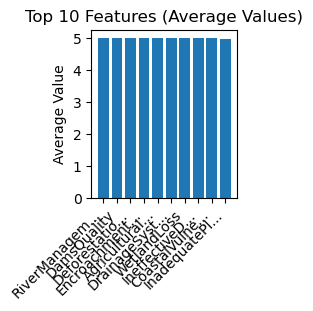

In [72]:
plt.subplot(2, 3, 3)
feature_means = data.drop('FloodProbability', axis=1).mean().sort_values(ascending=False)[:10]
plt.bar(range(len(feature_means)), feature_means.values)
plt.title('Top 10 Features (Average Values)')
plt.xticks(range(len(feature_means)), 
           [name[:12] + '...' if len(name) > 12 else name for name in feature_means.index], 
           rotation=45, ha='right')
plt.ylabel('Average Value')

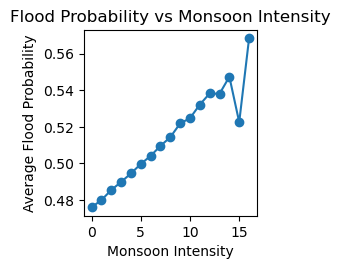

In [73]:

plt.subplot(2, 3, 4)
monsoon_flood = data.groupby('MonsoonIntensity')['FloodProbability'].mean()
plt.plot(monsoon_flood.index, monsoon_flood.values, marker='o')
plt.title('Flood Probability vs Monsoon Intensity')
plt.xlabel('Monsoon Intensity')
plt.ylabel('Average Flood Probability')
plt.tight_layout()
plt.show()

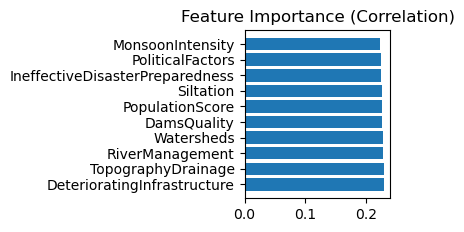

In [74]:

plt.subplot(2, 3, 5)

feature_importance = data.corr()['FloodProbability'].abs().sort_values(ascending=False)[1:11]
plt.barh(range(len(feature_importance)), feature_importance.values)
plt.yticks(range(len(feature_importance)), feature_importance.index)
plt.title('Feature Importance (Correlation)')

plt.show()


In [75]:

print("\n PREPARING DATA FOR MACHINE LEARNING...")

X = data.drop('FloodProbability', axis=1)  
y = data['FloodProbability']               
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


 PREPARING DATA FOR MACHINE LEARNING...
Features (X): (50000, 20)
Target (y): (50000,)
Training set: 40000 samples
Testing set: 10000 samples


In [76]:

print("\n2️ Training Random Forest...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
print(f"Random Forest trained in: {rf_time:.2f} seconds")


2️ Training Random Forest...
Random Forest trained in: 82.91 seconds


In [77]:

print("\n3️ Training XGBoost...")
start_time = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time
print(f"XGBoost trained in: {xgb_time:.2f} seconds")


3️ Training XGBoost...
XGBoost trained in: 1.04 seconds


In [78]:
def evaluate_model(model, model_name):

    y_pred = model.predict(X_test)
    

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  Root Mean Squared Error: {np.sqrt(mse):.4f}")
    
    return y_pred, r2, mse

rf_pred, rf_r2, rf_mse = evaluate_model(rf_model, "Random Forest")
xgb_pred, xgb_r2, xgb_mse = evaluate_model(xgb_model, "XGBoost")


Random Forest Results:
  R² Score: 0.7295
  Mean Squared Error: 0.0007
  Root Mean Squared Error: 0.0260

XGBoost Results:
  R² Score: 0.9252
  Mean Squared Error: 0.0002
  Root Mean Squared Error: 0.0136


In [79]:
print("\n PARALLEL PROCESSING DEMONSTRATION WITH PERFORMANCE EVALUATION")

def train_and_evaluate_model(model_info, X_train, y_train, X_test, y_test):
    """Function to train a model and return comprehensive evaluation metrics"""
    model_name, model = model_info
    
    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluation
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        'name': model_name,
        'training_time': training_time,
        'r2_score': r2,
        'mse': mse,
        'rmse': rmse
    }



 PARALLEL PROCESSING DEMONSTRATION WITH PERFORMANCE EVALUATION...


In [80]:
print("\n SERIAL TRAINING (using single core, n_jobs=1):")
serial_models = [
    ("Random Forest (Serial)", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)),
    ("XGBoost (Serial)", xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=1))
]

serial_results = []
for model_info in serial_models:
    print(f"Training {model_info[0]}...")
    result = train_and_evaluate_model(model_info, X_train, y_train, X_test, y_test)
    serial_results.append(result)
    print(f"  Time: {result['training_time']:.3f}s, R²: {result['r2_score']:.4f}, RMSE: {result['rmse']:.4f}")



 SERIAL TRAINING (using single core, n_jobs=1):
Training Random Forest (Serial)...
  Time: 75.030s, R²: 0.7295, RMSE: 0.0260
Training XGBoost (Serial)...
  Time: 1.183s, R²: 0.9252, RMSE: 0.0136


In [81]:
print(f"\n PARALLEL TRAINING (using all cores, n_jobs=-1):")
parallel_models = [
    ("Random Forest (Parallel)", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("XGBoost (Parallel)", xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
]

parallel_results = []
for model_info in parallel_models:
    print(f"Training {model_info[0]}...")
    result = train_and_evaluate_model(model_info, X_train, y_train, X_test, y_test)
    parallel_results.append(result)
    print(f"   Time: {result['training_time']:.3f}s, R²: {result['r2_score']:.4f}, RMSE: {result['rmse']:.4f}")


 PARALLEL TRAINING (using all cores, n_jobs=-1):
Training Random Forest (Parallel)...
   Time: 54.287s, R²: 0.7295, RMSE: 0.0260
Training XGBoost (Parallel)...
   Time: 1.013s, R²: 0.9252, RMSE: 0.0136



 CREATING COMPARISON VISUALIZATION...


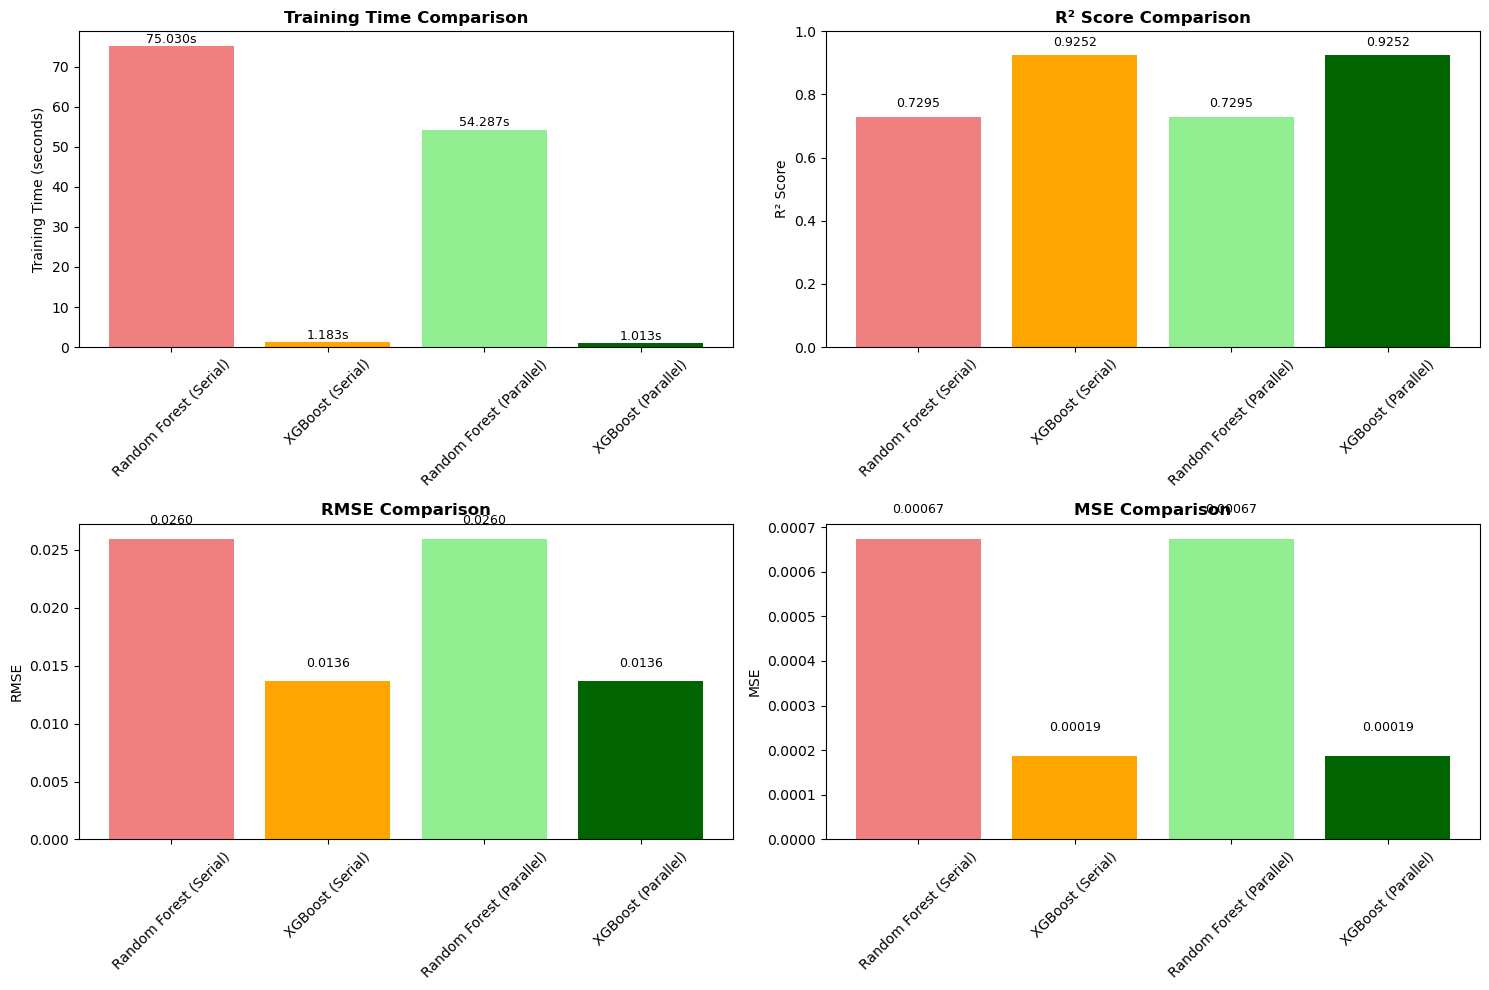

In [82]:

print(f"\n CREATING COMPARISON VISUALIZATION...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))


all_results = serial_results + parallel_results
model_names = [result['name'] for result in all_results]
colors = ['lightcoral', 'orange', 'lightgreen', 'darkgreen']

# Plot 1: Training Time Comparison
training_times = [result['training_time'] for result in all_results]
bars1 = ax1.bar(model_names, training_times, color=colors)
ax1.set_title('Training Time Comparison', fontweight='bold')
ax1.set_ylabel('Training Time (seconds)')
ax1.tick_params(axis='x', rotation=45)
for bar, time_val in zip(bars1, training_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{time_val:.3f}s', ha='center', va='bottom', fontsize=9)

# Plot 2: R² Score Comparison
r2_scores = [result['r2_score'] for result in all_results]
bars2 = ax2.bar(model_names, r2_scores, color=colors)
ax2.set_title('R² Score Comparison', fontweight='bold')
ax2.set_ylabel('R² Score')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)
for bar, score in zip(bars2, r2_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: RMSE Comparison
rmse_scores = [result['rmse'] for result in all_results]
bars3 = ax3.bar(model_names, rmse_scores, color=colors)
ax3.set_title('RMSE Comparison', fontweight='bold')
ax3.set_ylabel('RMSE')
ax3.tick_params(axis='x', rotation=45)
for bar, score in zip(bars3, rmse_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 4: MSE Comparison
mse_scores = [result['mse'] for result in all_results]
bars4 = ax4.bar(model_names, mse_scores, color=colors)
ax4.set_title('MSE Comparison', fontweight='bold')
ax4.set_ylabel('MSE')
ax4.tick_params(axis='x', rotation=45)
for bar, score in zip(bars4, mse_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.00005,
             f'{score:.5f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [83]:
# Summary table
print(f"\n PERFORMANCE COMPARISON TABLE:")

print(f"{'Model':<25} {'Training Time':<15} {'R² Score':<12} {'RMSE':<12} {'MSE':<15}")

for result in all_results:
    print(f"{result['name']:<25} {result['training_time']:<15.3f} {result['r2_score']:<12.4f} {result['rmse']:<12.4f} {result['mse']:<15.6f}")




 PERFORMANCE COMPARISON TABLE:
Model                     Training Time   R² Score     RMSE         MSE            
Random Forest (Serial)    75.030          0.7295       0.0260       0.000674       
XGBoost (Serial)          1.183           0.9252       0.0136       0.000186       
Random Forest (Parallel)  54.287          0.7295       0.0260       0.000674       
XGBoost (Parallel)        1.013           0.9252       0.0136       0.000186       


In [84]:
print("\n FEATURE IMPORTANCE ANALYSIS")


feature_names = X.columns
rf_importance = rf_model.feature_importances_


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print("\n TOP 10 MOST IMPORTANT FEATURES:")
print(importance_df.head(10))



 FEATURE IMPORTANCE ANALYSIS

 TOP 10 MOST IMPORTANT FEATURES:
                            Feature  Importance
1                TopographyDrainage    0.053020
6                       DamsQuality    0.052789
19                 PoliticalFactors    0.052384
10  IneffectiveDisasterPreparedness    0.051635
16                  PopulationScore    0.051615
2                   RiverManagement    0.051396
13                       Landslides    0.050995
8             AgriculturalPractices    0.050673
15      DeterioratingInfrastructure    0.050642
14                       Watersheds    0.050545


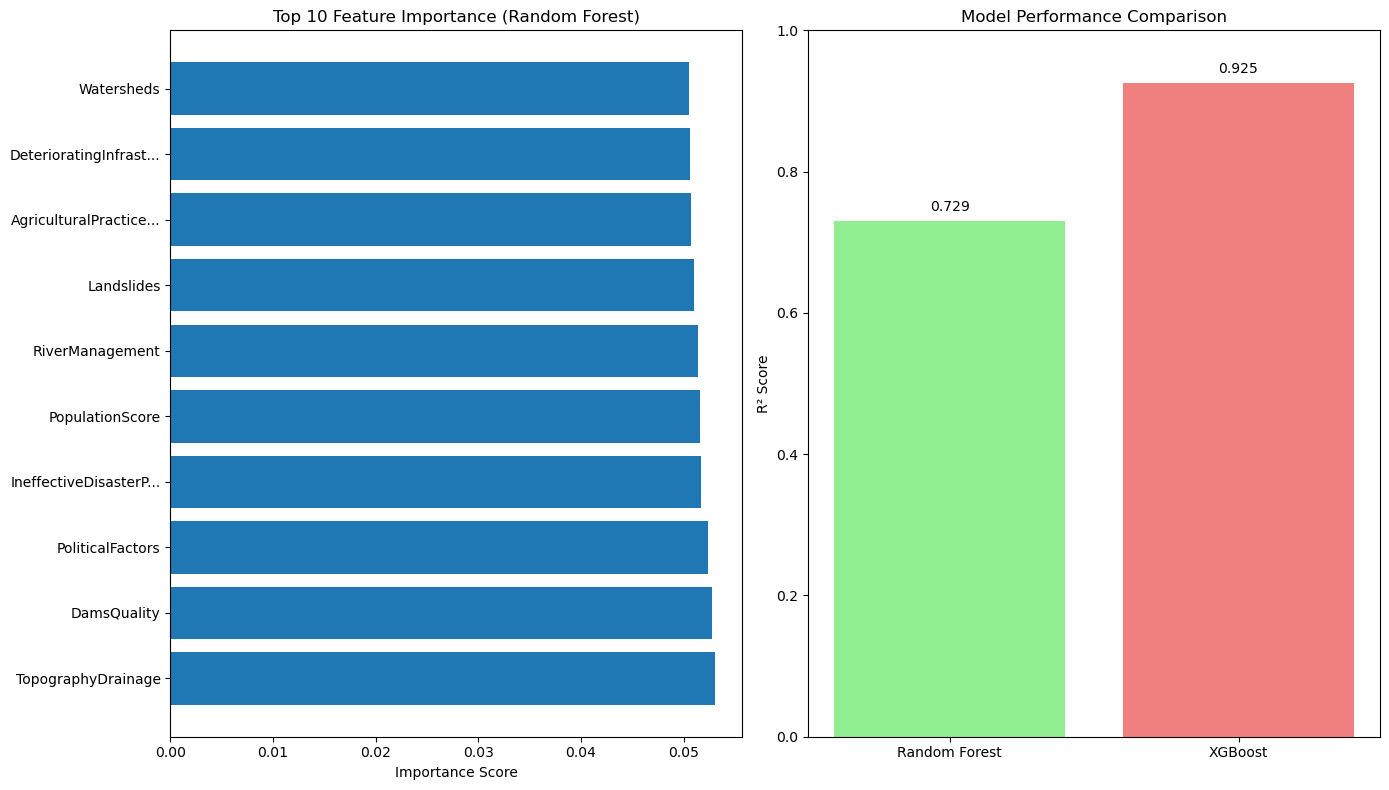

In [85]:

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
top_10_features = importance_df.head(10)
plt.barh(range(len(top_10_features)), top_10_features['Importance'])
plt.yticks(range(len(top_10_features)), 
           [name[:20] + '...' if len(name) > 20 else name for name in top_10_features['Feature']])
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')

plt.subplot(1, 2, 2)
model_names = ['Random Forest', 'XGBoost']
r2_scores = [rf_r2, xgb_r2]
colors = ['lightgreen', 'lightcoral']

bars = plt.bar(model_names, r2_scores, color=colors)
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1)


for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [86]:
print("\n MAKING PREDICTIONS ON NEW DATA...")

sample_data = pd.DataFrame({
    'MonsoonIntensity': [8],
    'TopographyDrainage': [3],
    'RiverManagement': [4],
    'Deforestation': [7],
    'Urbanization': [9],
    'ClimateChange': [8],
    'DamsQuality': [2],
    'Siltation': [6],
    'AgriculturalPractices': [5],
    'Encroachments': [7],
    'IneffectiveDisasterPreparedness': [8],
    'DrainageSystems': [3],
    'CoastalVulnerability': [6],
    'Landslides': [5],
    'Watersheds': [4],
    'DeterioratingInfrastructure': [7],
    'PopulationScore': [8],
    'WetlandLoss': [6],
    'InadequatePlanning': [7],
    'PoliticalFactors': [5]
})

print("Sample Input Data:")
print(sample_data.T) 

rf_prediction = rf_model.predict(sample_data)[0]
xgb_prediction = xgb_model.predict(sample_data)[0]

print(f"\n FLOOD PROBABILITY PREDICTIONS:")
print(f"Random Forest: {rf_prediction:.3f} ({rf_prediction*100:.1f}%)")
print(f"XGBoost: {xgb_prediction:.3f} ({xgb_prediction*100:.1f}%)")
print(f"Average Prediction: {np.mean([rf_prediction, xgb_prediction]):.3f}")


 MAKING PREDICTIONS ON NEW DATA...
Sample Input Data:
                                 0
MonsoonIntensity                 8
TopographyDrainage               3
RiverManagement                  4
Deforestation                    7
Urbanization                     9
ClimateChange                    8
DamsQuality                      2
Siltation                        6
AgriculturalPractices            5
Encroachments                    7
IneffectiveDisasterPreparedness  8
DrainageSystems                  3
CoastalVulnerability             6
Landslides                       5
Watersheds                       4
DeterioratingInfrastructure      7
PopulationScore                  8
WetlandLoss                      6
InadequatePlanning               7
PoliticalFactors                 5

 FLOOD PROBABILITY PREDICTIONS:
Random Forest: 0.543 (54.3%)
XGBoost: 0.585 (58.5%)
Average Prediction: 0.564


In [87]:
print("\n SUMMARY:")

print("\n KEY FINDINGS:")
print(f"• Best performing model: {'Random Forest' if rf_r2 > xgb_r2 else 'XGBoost'}")
print(f"• Parallel processing speedup: {serial_time/parallel_time:.1f}x")
print(f"• Most important feature: {importance_df.iloc[0]['Feature']}")



 SUMMARY:

 KEY FINDINGS:
• Best performing model: XGBoost
• Parallel processing speedup: 0.9x
• Most important feature: TopographyDrainage
